In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.051707  0.219105  0.449233 -0.170859  0.531777 -0.297064 -0.631073   
  1   0.587213  0.671876  0.455220  0.208033 -0.198735 -0.947789  0.015919   
  2   1.134922  0.513277 -0.927445 -0.266660  0.473171  0.453674 -0.359527   
  3  -0.157855  0.335820  0.047819  0.270581  0.125139 -0.221271  0.728162   
  4  -0.119745 -0.028740 -0.662376  0.059171 -0.443816 -0.203049 -0.055212   
  5   0.775912  0.306402  0.008575 -0.542722  0.191662  0.177200  0.164658   
  6  -0.571006 -1.176243 -0.236112  0.875127  1.017504 -0.315291 -0.545818   
  7   0.173031  0.696474  0.140446 -0.153941  0.876731 -0.445016 -0.593756   
  8   0.615684  1.035854 -1.072480  0.128229  0.277650 -0.565694 -0.567704   
  9  -0.491422 -0.244853  1.033406  0.313433  0.280302 -0.220537  0.784040   
  10  0.787756  0.445217 -0.154805  0.353265 -0.061143 -0.558392  0.512179   
  11 -0.825731  0.314438 -0.363521 -0.289132 -1.444251 -0.167613  0.743522   
  12  1.317561  0.183824  0.594649  0.317665 -0.953251  0.625636 -0.247292   
  13 -0.291976 -0.291832 -0.033370 -0.001530  0.019736 -1.184201 -0.217920   
  14 -0.212972  0.043550  0.357581  0.940133  0.030639  0.638770  0.878770   
  15  0.060227  0.377522 -1.446618 -0.772406  0.147509  0.629127 -0.832361   
  16  0.241129  0.537433 -0.753101 -0.794859 -0.978211 -0.288396 -0.126380   
  17 -0.829961 -0.360910  0.075303 -0.459712  0.704962  0.236957 -0.172651   
  18  0.889186 -0.221923  0.310931  0.645528 -0.568177 -1.090443  0.164889   
  19 -0.040286  0.201855 -0.053369  0.471194  0.328604 -0.344662 -0.207622   
  20 -0.094743 -0.744853 -1.436742  0.365611  0.437629 -0.175097 -0.030778   
  21 -0.013938  0.034204  0.579924 -0.035681  0.287296 -0.108557 -0.570664   
  22 -0.284167 -0.421941 -0.583750 -0.695260  0.813875  0.347404 -0.131473   
  23  1.347546  1.014038  0.972223 -0.055451 -0.467641  0.501846  0.633255   
  24  0.121440 -0.096028 -0.260533 -0.604326 -0.566024 -0.864279 -0.374231   
1 0  -1.260171 -0.466741 -0.361579 -0.301358  0.605992 -0.738758 -1.169150   
  1   1.188095  0.173111 -0.125666  0.450680 -0.222429  0.364881 -0.075835   
  2   0.319508  0.166363 -0.634455 -0.562591 -0.670495  0.575373 -0.844223   
  3  -0.658045 -0.789585 -0.062973  0.040580  0.497049 -0.207654 -0.546356   
  4  -0.619648 -0.261660 -0.682959 -0.681431 -0.528082  0.311250 -0.387650   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.291352 -0.283654 -0.083944  ...  0.220539 -0.573354 -0.760369   
  1   0.429688  0.801403 -0.308495  ...  0.020781  0.648305 -0.321424   
  2   0.784808 -0.617796 -0.676337  ...  0.106846 -0.199649  1.041438   
  3   1.113345  0.055139  0.370229  ... -0.284268 -0.874405 -0.311622   
  4  -0.060767 -0.422826 -0.183693  ...  1.101825 -0.424769 -1.612558   
  5   0.781089  0.139188 -0.728139  ... -0.083965 -0.197845 -0.657547   
  6  -1.309114 -2.322143 -1.127194  ...  0.121108 -0.204753  0.477480   
  7   1.077017  0.676584  0.730718  ...  0.608945 -0.872742 -0.114058   
  8   1.889666  0.936421  0.561580  ...  0.711366  0.685154  0.249783   
  9   1.231346 -0.277678 -0.233442  ...  0.929989  0.553588 -0.155920   
  10  0.843158 -0.002282 -0.966339  ...  0.441962  0.503226  0.210743   
  11  1.387235  0.782462  1.335317  ...  1.095792 -0.468728  0.467838   
  12  0.408552 -0.452136 -0.026036  ...  0.620297 -1.083531  0.481512   
  13  0.327271 -0.391411 -0.104995  ... -0.138529 -0.450690  0.214830   
  14  0.905997 -0.307027 -0.727498  ...  0.762579 -0.245386  0.328779   
  15  0.588545 -0.105281 -0.043632  ...  0.347679 -0.151078  1.048592   
  16 -0.388018 -0.508127  0.667955  ... -0.395935 -0.305332  0.321606   
  17 -0.005944 -0.843661 -0.209254  ...  0.336375  0.214227  1.064425   
  18  0.327865 -0.090108 -1.307556  ...  0.346655 -0.267713  0.064782   
  19  0.715457  0.096763 -0.156327  ...  0.668300  0.429427 -0.947302   
  20  0.086280  0.069645  0.018857  ...  0.849222  0.030684 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.201182  0.036514  32.896843  2.438608e-237  1.129617  1.272747


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



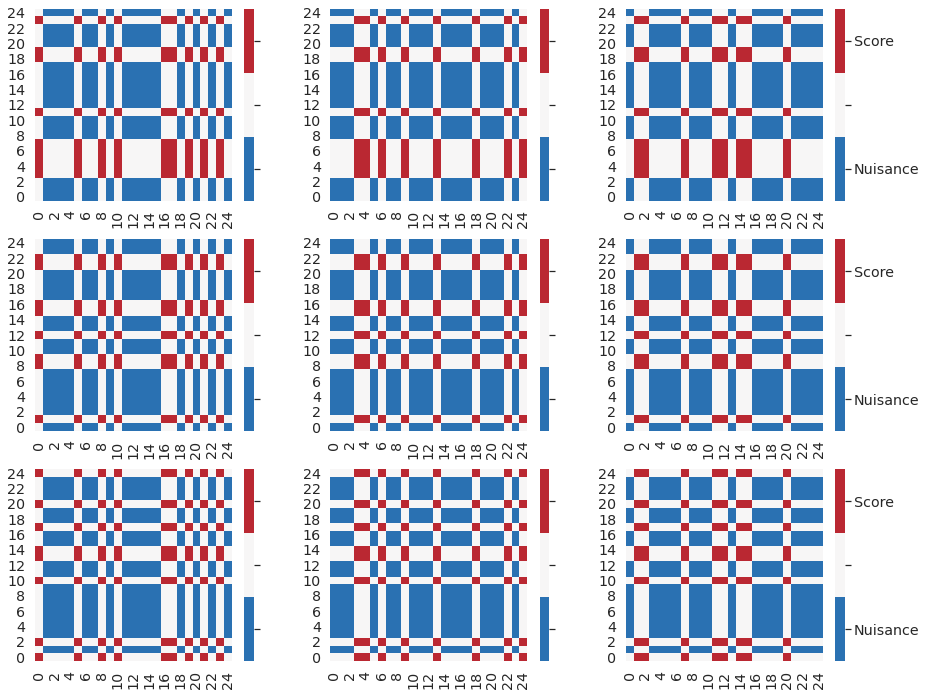

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



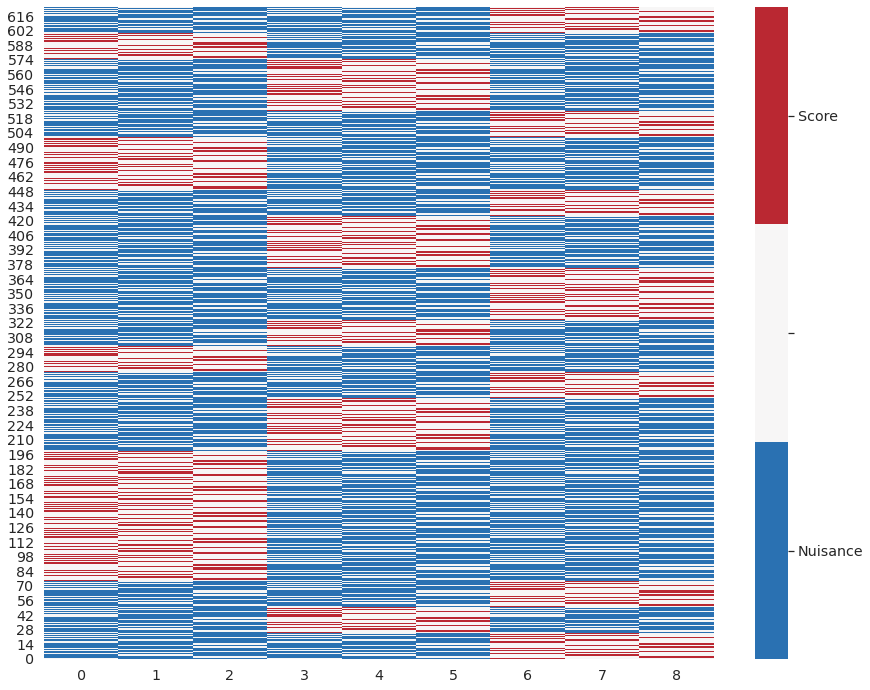

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])